# Ham/Spam SMS classfication

## Problem Statement

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains set of 5,574 messages in English, Messages are tagged being ham (legitimate) or spam. The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

### This Spam_Check_Model.ipynb is having descriptive analysis and various algorithmic models and their accuracy of classification for the given data set.Hyper parameter tuning is done in Spam_Check_HPT.ipynb

In [3]:
#importing necessary libararies
#importing necessary libararies
#nltk.downlaod will be used to download the necessary files

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Kalaiyarasan
[nltk_data]     Jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Kalaiyarasan
[nltk_data]     Jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [223]:
!pip install wordcloud
from wordcloud import WordCloud

In [5]:
#Reading the source CSV file and encod
#url="https://www.kaggle.com/uciml/sms-spam-collection-dataset"
df=pd.read_csv('spam.csv',encoding='latin-1')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
#viewing the Dataframe and its columns
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
#showing the column names
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

## Descriptive analysis of the data

In [9]:
#Removing columns which has Nan's or unknown values
df.dropna(axis=1,inplace=True)
df.rename(columns={'v1':'class','v2':'Message'},inplace=True)

df['length'] = df['Message'].map(lambda text: len(text))
print(df.head())


  class                                            Message  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61


In [10]:
#getting longer message length
max(df['length'])
df[df['length'] ==910].index.values

array([1084], dtype=int64)

In [11]:
#viewing the longer messages
df.iloc[1084,1]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [12]:
df.groupby('class').describe()

length                                                         
        count        mean        std   min    25%    50%    75%    max
class                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0

#### Dealing with the 13% event rate and it might not be the case for imbalanced data set ,So proceeding further without resampling

## Data preprocessing 

### Escaping HTML enities

In [15]:
#removing HTML entities by html.unescape
import html
def html_escape(text):
    return html.unescape(text)
df['Message']=df['Message'].apply(html_escape)


### Stopwords check,lower char conversion,Stemming using Porter stemmer

#### Taking all charecters(alpha,numeric,symbols) due to natural language conversations. And also tested the model by taking only alphanumeric then the model giving the misclassications in higher range, So we are able to understand the symbols also make the huge impact in the classification.

#### we have used Porterstemmer to stem the word and got improved by the accuracy with other stemmer like SnowBall stemmer

In [13]:
def pre_process(text):
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    #text = [word for word in text if word.isalnum()]
    words = ""
    table=str.maketrans('','',string.punctuation)
    stemmer = PorterStemmer()
    for word in text:
        word=word.strip()
        if word.isalpha():
            word=word.translate(table)
            #words += (stemmer.stem(word.lower()))+" "
            word=stemmer.stem(word.lower())
            if len(word)>1:
                words +=word+" "
            
    return words

In [14]:
Features = df['Message'].copy()
Features = Features.apply(pre_process)

### Labeling the target feature as Class and assigning value '0' to ham message and assigning the value '1' to spam message

In [15]:
df.loc[df['class']=='ham','class']=0
df.loc[df['class']=='spam','class']=1

## Train and Test Split

In [16]:
vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(Features)

features_train, features_test, labels_train, labels_test = train_test_split(features, df['class'], test_size=0.3, random_state=111)




## Modeling with various algorithms

## Naive bayes
### Multinomial Naive Bayes classifier is suitable for classification with discrete features for example Text classfication.Fitting the model and calculating the accuracy

In [51]:
train_data_accuracy=[]
test_data_accuracy=[]
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
mnb = MultinomialNB(alpha=0.16)
Predicted_accuracy=cross_val_score(mnb,features_train,labels_train,cv=10)
print("k fold cross validation score",Predicted_accuracy.mean())
mnb.fit(features_train, labels_train)


k fold cross validation score 0.9687072235846388


MultinomialNB(alpha=0.16, class_prior=None, fit_prior=True)

In [52]:
train_pred=mnb.predict(features_train)
train_data_accuracy.append(accuracy_score(labels_train,train_pred))
print("accurcy of the training data is :",accuracy_score(labels_train,train_pred))


accurcy of the training data is : 0.9889743589743589


In [53]:
prediction = mnb.predict(features_test)
test_data_accuracy.append(accuracy_score(labels_test,prediction))
print("Accuracy score for Test data in multinomial NB classifier is : ",accuracy_score(labels_test,prediction))

Accuracy score for Test data in multinomial NB classifier is :  0.9748803827751196


### Gaussian Naive Bayes classifier

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
X_train=features_train.toarray()
X_test=features_test.toarray()
Predicted_accuracy=cross_val_score(gnb,X_train,labels_train,cv=10)
print("k fold cross validation score",Predicted_accuracy.mean())
gnb.fit(X_train, labels_train)


k fold cross validation score 0.7797217601693635


GaussianNB(priors=None)

In [55]:
train_pred=gnb.predict(X_train)
train_data_accuracy.append(accuracy_score(labels_train,train_pred))
print("accurcy of the training data is :",accuracy_score(labels_train,train_pred))


accurcy of the training data is : 0.8546153846153847


In [57]:
prediction = gnb.predict(X_test)
test_data_accuracy.append(accuracy_score(labels_test,prediction))
print("Accuracy score for Test data in GaussianNB NB classifier is : ",accuracy_score(labels_test,prediction))

Accuracy score for Test data in GaussianNB NB classifier is :  0.7960526315789473


### Bernoulli Naive Bayes

In [58]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB(alpha=0.38)
X_train=features_train.toarray() 
X_test=features_test.toarray()
Predicted_accuracy=cross_val_score(bnb,X_train,labels_train,cv=10)
print("k fold cross validation score",Predicted_accuracy.mean())
bnb.fit(X_train, labels_train)


k fold cross validation score 0.971295011801524


BernoulliNB(alpha=0.38, binarize=0.0, class_prior=None, fit_prior=True)

In [59]:
train_pred=bnb.predict(X_train)
train_data_accuracy.append(accuracy_score(labels_train,train_pred))
print("accurcy of the training data is :",accuracy_score(labels_train,train_pred))


accurcy of the training data is : 0.9866666666666667


In [61]:
prediction = bnb.predict(X_test)
test_data_accuracy.append(accuracy_score(labels_test,prediction))
print("Accuracy score for Test data in Bernoulli NB classifier is : ",accuracy_score(labels_test,prediction))

Accuracy score for Test data in Bernoulli NB classifier is :  0.9754784688995215


In [76]:
test_data_accuracy=[round(i,4) for i in test_data_accuracy]

In [77]:
train_data_accuracy=[round(i,4) for i in train_data_accuracy]

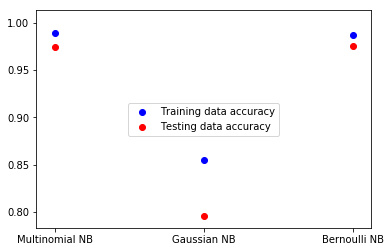

In [112]:
models=['Multinomial NB','Gaussian NB','Bernoulli NB']
plt.scatter(models,train_data_accuracy,color='Blue',label='Training data accuracy')
plt.scatter(models,test_data_accuracy,color='Red',label='Testing data accuracy')
plt.legend(loc='center')
plt.show()

## Important Features for the classifier represented using World cloud

Text(0.5,1,'HAM')

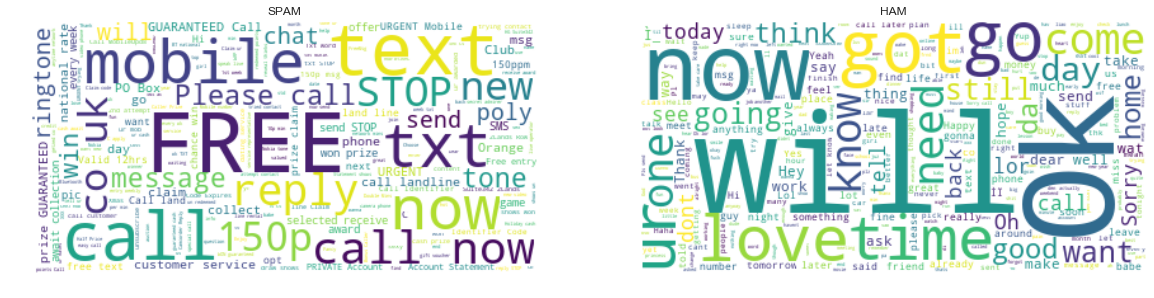

In [228]:
ham_data=' '.join(df.loc[df['class']==0,'Message'].values)
ham_wordcloud=WordCloud(background_color='white',max_words=2000).generate(ham_data)
spam_data=' '.join(df.loc[df['class']==1,'Message'].values)
spam_wordcloud=WordCloud(background_color='white',max_words=2000).generate(spam_data)
plt.figure(figsize=[20,30])
plt.subplot(1,2,1)
plt.imshow(spam_wordcloud,interpolation='bilinear')
plt.title('SPAM')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('HAM')